In [1]:
# import required packages
import gisutils
from pydrograph import Nwis
from pydrograph.attributes import streamflow_attributes
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
from matplotlib.ticker import FormatStrFormatter
# Import pydrograph 
# Must clone pydrograph to local machine, and place pydrograph subfolder in project directory
# pydrograph code: https://github.com/aleaf/pydrograph
import pydrograph 

## Process NWIS data
### NWIS sites
* USGS 13140800 BIG WOOD RIVER AT STANTON CROSSING NR BELLEVUE ID - above dam (upstream)
  * https://waterdata.usgs.gov/usa/nwis/uv?13140800
* USGS 13142500 BIG WOOD RIVER BL MAGIC DAM NR RICHFIELD ID - below dam (downstream)
  * https://waterdata.usgs.gov/usa/nwis/uv?13142500
* Import data following instructions in pydrograph README.md
  * https://github.com/aleaf/pydrograph

In [2]:
# define sites
magic_sites = {'above': 13140800, 'below': 13142500}

In [3]:
# set bounding box
magic_bbox = [-114.5, 43.5, -114.1, 43.1] # nw lon, nw lat, se lon, se lat
nwis = pydrograph.Nwis(magic_bbox)

In [4]:
# Generate a url to get field measurements for the bounding box
url = nwis.make_site_url('field_measurements', streamflow_attributes)

# Get a dataframe of site information for the bounding box (url is generated internally)
field_sites = nwis.get_siteinfo('field_measurements')

# Write the site information out to a shapefile
gisutils.df2shp(field_sites, 'NWIS_field_measurements.shp')

# Get inventory of daily values sites
dv_sites = nwis.get_siteinfo('daily_values')

getting site inventory for field_measurements...
url: http://nwis.waterdata.usgs.gov/usa/nwis/measurements?nw_longitude_va=-114.500&nw_latitude_va=43.100&se_longitude_va=-114.100&se_latitude_va=43.500&coordinate_format=decimal_degrees&group_key=NONE&format=sitefile_output&sitefile_output_format=rdb&column_name=site_no&column_name=station_nm&column_name=site_tp_cd&column_name=dec_lat_va&column_name=dec_long_va&column_name=coord_meth_cd&column_name=coord_acy_cd&column_name=coord_datum_cd&column_name=dec_coord_datum_cd&column_name=district_cd&column_name=state_cd&column_name=county_cd&column_name=country_cd&column_name=land_net_ds&column_name=map_nm&column_name=map_scale_fc&column_name=alt_va&column_name=alt_meth_cd&column_name=alt_acy_va&column_name=alt_datum_cd&column_name=huc_cd&column_name=basin_cd&column_name=topo_cd&column_name=inventory_dt&column_name=drain_area_va&column_name=contrib_drain_area_va&column_name=tz_cd&column_name=local_time_fg&column_name=reliability_cd&column_name=p

In [5]:
# confirm that we have data for our sites
dv_sites['site_no'].unique

<bound method Series.unique of site_no
13140335    13140335
13140500    13140500
13140800    13140800
13140900    13140900
13141000    13141000
13141070    13141070
13142000    13142000
13142500    13142500
13143000    13143000
13150200    13150200
13150430    13150430
Name: site_no, dtype: object>

In [6]:
# pull data for upstream site
above_raw = nwis.get_dvs(magic_sites['above'])

http://waterservices.usgs.gov/nwis/dv/?format=rdb&sites=13140800&startDT=1880-01-01&parameterCd=00060


In [7]:
# pull data for downstream site
below_raw = nwis.get_dvs(magic_sites['below'])

http://waterservices.usgs.gov/nwis/dv/?format=rdb&sites=13142500&startDT=1880-01-01&parameterCd=00060


In [8]:
# make copies of raw data
# in case we mess it up later -- we can get the original data without re-pulling it
above_df = above_raw.copy()
below_df = below_raw.copy()

In [9]:
# convert the datetime columns to pandas datetime
above_df['datetime'] = pd.to_datetime(above_df['datetime'])
below_df['datetime'] = pd.to_datetime(below_df['datetime'])

In [10]:
# filter the data to the desired timeframe
# in this case restricted by the period of record for the upstream site
above_df = above_df.loc[(above_df['datetime'] > '1996-09-30') & (above_df['datetime'] < '2020-10-01')]
below_df = below_df.loc[(below_df['datetime'] > '1996-09-30') & (below_df['datetime'] < '2020-10-01')]

In [11]:
# add a column for calendaar year and one for month
above_df['year'] = [i.year for i in above_df['datetime']]
below_df['year'] = [i.year for i in below_df['datetime']]
above_df['month'] = [i.month for i in above_df['datetime']]
below_df['month'] = [i.month for i in below_df['datetime']]

In [12]:
# add an empty column for water year and then populate it
### (defined as October 1 - September 30 -- https://water.usgs.gov/nwc/explain_data.html)
above_df['wateryear'] = np.nan
below_df['wateryear'] = np.nan
above_df.loc[above_df['month'] < 10, 'wateryear'] = above_df['year']
above_df.loc[above_df['month'] > 9, 'wateryear'] = above_df['year'] + 1
below_df.loc[below_df['month'] < 10, 'wateryear'] = below_df['year']
below_df.loc[below_df['month'] > 9, 'wateryear'] = below_df['year'] + 1

In [13]:
# make a new dataframe with a day-of-water-year (DOWY) column
# here we subset the data to one water year, then use the dataframe index
# (running from 0 - 364) to define the day of the water year
above_wy_df = []
for year in range(1997, 2021):
    above_subset = above_df.loc[above_df['wateryear'] == year]
    above_subset = above_subset.reset_index(drop=True)
    above_subset['DOWY'] = above_subset.index + 1
    above_wy_df.append(above_subset)
above_wy_df = pd.concat(above_wy_df)

In [14]:
# do the same for the downstream site
below_wy_df = []
for year in range(1997, 2021):
    below_subset = below_df.loc[below_df['wateryear'] == year]
    below_subset = below_subset.reset_index(drop=True)
    below_subset['DOWY'] = below_subset.index + 1
    below_wy_df.append(below_subset)
below_wy_df = pd.concat(below_wy_df)

In [15]:
# compute the median for each day of the water year
above_wy_median = above_wy_df.groupby('DOWY').median()
below_wy_median = below_wy_df.groupby('DOWY').median()

## Process spatial data
* Download data by drawn extent from https://apps.nationalmap.gov/downloader/#/
* Unzip downloaded data to geodatabase located in project directory

##### Magic reservoir polygon

In [16]:
# Load shapefile of all reservoirs in project extent
reservoirs = gpd.read_file("NHDPLUS_H_1704_HU4_GDB/NHDPLUS_H_1704_HU4_GDB.gdb", driver='FileGDB', layer='NHDWaterbody')

In [17]:
# Pull out magic reservoir
magic_reservoir = reservoirs.loc[reservoirs['GNIS_Name'] == 'Magic Reservoir']

In [18]:
# check projection?
magic_reservoir.crs

<Geographic 2D CRS: EPSG:4269>
Name: NAD83
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: North America - NAD83
- bounds: (167.65, 14.92, -47.74, 86.46)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [19]:
# reproject magic reservoir polygon to UTM zone 11N
magic_reservoir_proj = magic_reservoir.to_crs(epsg = '32611')

##### Bigwood River polyline and Camas Creek polyline

In [20]:
# Load shapefile of all rivers in extent
rivers = gpd.read_file("NHDPLUS_H_1704_HU4_GDB/NHDPLUS_H_1704_HU4_GDB.gdb", driver='FileGDB', layer='NHDFlowline')

In [21]:
# Pull out polyline for Bigwood River and Camas Creek
magic_rivers = rivers.loc[(rivers['GNIS_Name'] == 'Big Wood River') | (rivers['GNIS_Name'] == 'Camas Creek')]

In [22]:
# project polylines to UTM zone 11N
magic_rivers_proj = magic_rivers.to_crs(epsg = '32611')

##### Upstream and downstream points

In [23]:
# Load shapefile of all sites in extent
sites = gpd.read_file('NWIS_field_measurements.shp')

In [24]:
# Need to define projection, since undefined
sites.crs = 'EPSG:4269'

In [25]:
# Pull out above and below sites (site_no must be string)
bigwood_sites = sites.loc[(sites['site_no'] == str(magic_sites['above'])) | (sites['site_no'] == str(magic_sites['below']))]

In [26]:
# project points to UTM zone 11N
bigwood_sites_proj = bigwood_sites.to_crs(epsg = '32611')

In [27]:
# Make separate shapefiles for each site (for ease of plotting)
above_site = bigwood_sites_proj.loc[bigwood_sites_proj['site_no'] == str(magic_sites['above'])]
below_site = bigwood_sites_proj.loc[bigwood_sites_proj['site_no'] == str(magic_sites['below'])]

## Construct plot

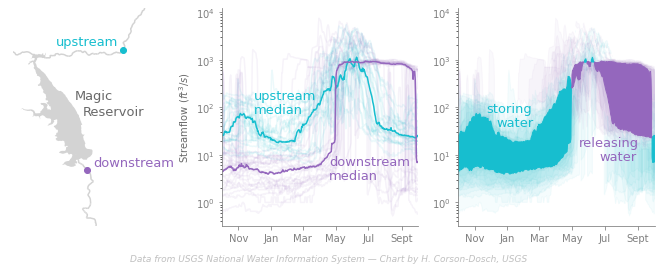

In [29]:
# Define figure parameters
fig = plt.figure(figsize=(12, 4))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133, sharey=ax2)
fontsize = 13

#######################################################################
### Make map of sites, Bigwood reservoir, Bigwood River and Camas Creek
#######################################################################
magic_rivers_proj.plot(ax = ax1, zorder=1, color = 'lightgrey')
magic_reservoir_proj.plot(ax = ax1, zorder=1, color = 'lightgrey')
above_site.plot(ax = ax1, color = 'tab:cyan', zorder=2)
below_site.plot(ax = ax1, color = 'tab:purple', zorder=2)
# Set x and y axis limits
ax1.set_xlim(709000,720000)
ax1.set_ylim(4.7875e6,4.804e6)
# turn of axes
ax1.set_axis_off()
# Add annotations
ax1.annotate('downstream', xy=(715100,4.792e6), color = 'tab:purple', fontsize=fontsize)
ax1.annotate('upstream', xy=(712270,4.8012e6), color = 'tab:cyan', fontsize=fontsize)
ax1.annotate('Magic', xy=(713700,4.7971e6), color = 'dimgrey', fontsize=fontsize)
ax1.annotate('Reservoir', xy=(714300,4.7959e6), color = 'dimgrey', fontsize=fontsize)
# tweak the position of ax1 slightly
box = ax1.get_position()
box.x0 = box.x0 + 0.002
box.x1 = box.x1 + 0.002
ax1.set_position(box)


#######################################################################
### Make streamflow plots (streamflow, median streamflow, difference)
#######################################################################
# Plot streamflow for each water year on ax2 and ax3
for year in range(1997, 2021):
    above_subset = above_df.loc[above_df['wateryear'] == year]
    below_subset = below_df.loc[below_df['wateryear'] == year]
    above_subset = above_subset.reset_index(drop=True)
    below_subset = below_subset.reset_index(drop=True)
    # plot streamflow for each water year on ax2
    # add one to index to match DOWY index of above_wy_median dataframe
    ax2.plot(above_subset.index + 1, above_subset['45750_00060_00003'], color='tab:cyan', alpha=0.08)
    ax2.plot(below_subset.index + 1, below_subset['45770_00060_00003'], color='tab:purple', alpha=0.08)
    # plot difference between streamflow at two sites for each water year as area on ax3
    ax3.fill_between(above_subset.index + 1, above_subset['45750_00060_00003'], below_subset['45770_00060_00003'], where=(above_subset['45750_00060_00003'] > below_subset['45770_00060_00003']), color='tab:cyan', alpha=0.04)
    ax3.fill_between(above_subset.index + 1, above_subset['45750_00060_00003'], below_subset['45770_00060_00003'], where=(above_subset['45750_00060_00003'] <= below_subset['45770_00060_00003']), color='tab:purple', alpha=0.04)   

# Plot median streamflow for each day of water year on ax2
ax2.plot(above_wy_median.index, above_wy_median['45750_00060_00003'], color='tab:cyan', alpha=1)
ax2.plot(below_wy_median.index, below_wy_median['45770_00060_00003'], color='tab:purple', alpha=1)
# Use log scale
ax2.set_yscale('log')

# Style ax2 axis label
ax2.set_ylabel('Streamflow ($ft^3/s$)', color='dimgrey')
# Add annotations
ax2.annotate('upstream', xy=(60,150), color = 'tab:cyan', fontsize=fontsize)
ax2.annotate('median', xy=(60,75), color = 'tab:cyan', fontsize=fontsize)
ax2.annotate('downstream', xy=(200,6), color = 'tab:purple', fontsize=fontsize)
ax2.annotate('median', xy=(200,3.1), color = 'tab:purple', fontsize=fontsize)

# Plot difference between median streamflow for each day of water year on ax3
# Plot in two chunks, so can color differently
# above > below
ax3.fill_between(above_wy_median.index, above_wy_median['45750_00060_00003'], below_wy_median['45770_00060_00003'], where=(above_wy_median['45750_00060_00003'] > below_wy_median['45770_00060_00003']), color='tab:cyan')
# above <= below
ax3.fill_between(above_wy_median.index, above_wy_median['45750_00060_00003'], below_wy_median['45770_00060_00003'], where=(above_wy_median['45750_00060_00003'] <= below_wy_median['45770_00060_00003']), color='tab:purple')
# Use log scale
ax3.set_yscale('log')

# Add annotations
ax3.annotate('storing', xy=(52,80), color = 'tab:cyan', fontsize=fontsize)
ax3.annotate('water', xy=(72,40), color = 'tab:cyan', fontsize=fontsize)
ax3.annotate('releasing', xy=(225,15), color = 'tab:purple', fontsize=fontsize)
ax3.annotate('water', xy=(263,7.7), color = 'tab:purple', fontsize=fontsize)

# Style ax2 and ax3 together
for i, a in enumerate([ax2, ax3]):
    a.spines["top"].set_visible(False)
    a.spines["right"].set_visible(False)
    a.spines["bottom"].set_edgecolor('grey')
    a.spines["left"].set_edgecolor('grey')
    a.spines["left"].set_color('grey')
    a.tick_params(axis = 'y', colors = 'grey')
    for line in a.get_yticklines():
        line.set_color('grey')
    a.set_xticks([31, 92, 151, 212, 273, 335])
    a.set_xticklabels(['Nov', 'Jan', 'Mar', 'May', 'Jul', 'Sept'])
    a.set_xlim(0,366)
    for line in a.get_xticklines():
        line.set_color('grey')
    for label in a.get_xticklabels():
        label.set_color('grey')

# Add attribution text
plt.annotate('Data from USGS National Water Information System — Chart by H. Corson-Dosch, USGS', xy=(130,5), xycoords='figure points' ,color = 'silver', fontsize=9, fontstyle='italic')

# Save figure
plt.savefig('magic.png', bbox_inches='tight', dpi=300)